In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from TINTOlib.tinto import TINTO
from vit_pytorch.vit import ViT
from kan import *


import time
import gc
import copy
import traceback
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import torch.optim as optim
import torch

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [4]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
folder="data/1000-Cameras-Dataset"
x_col=["Release_date", "Max_resolution", "Low_resolution", "Effective_pixels", "Zoom", "Normal_focus_range", "Macro_focus_range", "Storage_included","Weight","Dimensions"]
target_col=["price"]

In [6]:
def load_and_clean(npy_filename, y_filename, x_col, target_col):
    """
    Load the feature array (npy_filename) and label array (y_filename),
    drop rows in the feature array that contain any NaNs, and apply
    the same mask to the label array.
    """
    # Load numpy arrays
    X = np.load(os.path.join(folder, npy_filename))
    y = np.load(os.path.join(folder, y_filename))
    
    # Ensure the number of rows matches between X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError("The number of rows in {} and {} do not match.".format(npy_filename, y_filename))
    
    # Create a boolean mask for rows that do NOT have any NaN values in X
    valid_rows = ~np.isnan(X).any(axis=1)

    # Filter both arrays using the valid_rows mask
    X_clean = X[valid_rows]
    y_clean = y[valid_rows]
    
    # Convert arrays to DataFrames
    df_X = pd.DataFrame(X_clean)
    df_y = pd.DataFrame(y_clean)
    df_X.columns = x_col
    df_y.columns = target_col
    return df_X, df_y

X_train, y_train = load_and_clean('N_train.npy', 'y_train.npy',x_col, target_col)
X_test, y_test   = load_and_clean('N_test.npy',  'y_test.npy', x_col, target_col)
X_val, y_val     = load_and_clean('N_val.npy',   'y_val.npy', x_col, target_col)

In [7]:
X_train = pd.concat([X_train, y_train], axis=1)
X_test = pd.concat([X_test, y_test], axis=1)
X_val = pd.concat([X_val, y_val], axis=1)

In [8]:
def load_and_preprocess_data(X_train, X_test, X_val, images_folder, image_model, problem_type, batch_size=32, device='cuda'):
    """Loads, processes, and converts a dataset into PyTorch DataLoaders for a ViT + KAN model."""
    
    # Reset indices
    data_splits = {
        "train": X_train.reset_index(drop=True), 
        "val": X_val.reset_index(drop=True), 
        "test": X_test.reset_index(drop=True)
    }
    
    # Process images and numerical features
    num_features, img_paths, targets = {}, {}, {}

    for split, X_split in data_splits.items():
        split_folder = f"{images_folder}/{split}"
        os.makedirs(split_folder, exist_ok=True)

        # Ensure images and CSV files are generated
        image_model.fit_transform(X_split, split_folder) if split == "train" else image_model.transform(X_split, split_folder)

        # Validate CSV file existence
        csv_path = os.path.join(split_folder, f"{problem_type}.csv")
        if not os.path.exists(csv_path):
            print(f"Error: Missing CSV at {csv_path}. Available files: {os.listdir(split_folder)}")
            raise FileNotFoundError(f"Expected file {csv_path} not found. Ensure image_model generates it.")

        print(f"Loading {csv_path}...")
        img_df = pd.read_csv(csv_path)
        img_df["images"] = split_folder + "/" + img_df["images"]

        # Combine numerical data and images
        combined_df = pd.concat([img_df, X_split], axis=1)
        num_features[split] = combined_df.drop(columns=["values", "images", X_train.columns[-1]])
        img_paths[split] = img_df["images"]
        targets[split] = combined_df["values"]

    # Standardize numerical data
    scaler = StandardScaler()
    for split in ["train", "val", "test"]:
        num_features[split] = pd.DataFrame(scaler.fit_transform(num_features[split]) if split == "train" 
                                           else scaler.transform(num_features[split]), 
                                           columns=num_features[split].columns)

    # Convert images to tensors
    img_tensors = {split: torch.tensor(np.array([cv2.imread(img) for img in img_paths[split]]), 
                                       dtype=torch.float32, device=device).permute(0, 3, 1, 2) / 255.0
                   for split in ["train", "val", "test"]}
    
    # Get dataset properties
    attributes = num_features["train"].shape[1]
    channels, height, width = img_tensors["train"].shape[1:]
    imgs_shape = (channels, height, width)

    print("Images shape:", imgs_shape)
    print("Attributes:", attributes)

    # Convert numerical data and targets to tensors
    num_tensors = {split: torch.tensor(num_features[split].values, dtype=torch.float32, device=device)
                   for split in ["train", "val", "test"]}
    
    target_tensors = {split: torch.tensor(targets[split].values, dtype=torch.float32, device=device).reshape(-1, 1)
                      for split in ["train", "val", "test"]}

    # Create DataLoaders
    datasets = {split: TensorDataset(num_tensors[split], img_tensors[split], target_tensors[split]) 
                for split in ["train", "val", "test"]}
    
    data_loaders = {split: DataLoader(datasets[split], batch_size=batch_size, shuffle=(split == "train")) 
                    for split in ["train", "val", "test"]}

    return data_loaders["train"], data_loaders["val"], data_loaders["test"], attributes, imgs_shape


In [10]:
from TINTOlib.tinto import TINTO
problem_type = "regression"
image_model = TINTO(problem=problem_type, blur=True, random_seed=SEED)
images_folder = "./HyKANImages/1000Cameras"

In [11]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, X_test, X_val,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=32
)

Loading ./HyKANImages/1000Cameras/train\regression.csv...
Loading ./HyKANImages/1000Cameras/val\regression.csv...
Loading ./HyKANImages/1000Cameras/test\regression.csv...
Images shape: (3, 20, 20)
Attributes: 10


In [13]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, patch_size, device):
        super(Model1, self).__init__()
        self.device = device
        # ViT branch
        self.vit = ViT(
            image_size = imgs_shape,
            patch_size = patch_size,
            dim = 32,
            depth = 2,
            heads = 4,
            mlp_dim = 64,
            dropout = 0.1,
            emb_dropout = 0.1
        ).to(device)

        self.m_kan = KAN(
            width=[attributes, 10],
            grid=3,
            k=3,
            seed=SEED,
            device=device
        )

        self.final_kan = KAN(
            width=[32+10, 1],
            grid=4,
            k=3,
            seed=SEED,
            device=device
        )


    def forward(self, mlp_input, vit_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        vit_input = vit_input.to(self.device)
        
        vit_output = self.vit(vit_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        concat_output = torch.cat((kan_output, vit_output), dim=1)
        return self.final_kan(concat_output)

In [12]:
def try_create_model(model_class, patch_size, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape[1:], patch_size, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}: {str(e)}")
        traceback.print_exc()
        return None

In [14]:
patch_size = 2
model1 = try_create_model(Model1, patch_size, attributes, imgs_shape, device)  # Attempt to create Model1

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model1


In [38]:
train_loader

In [15]:
def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=10, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [16]:
dataset_name = '1000cameras'
name = f"TINTO"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=120, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)


Training completed in 298.79 seconds
Best model found at epoch 120/120
Best Train Loss: 352820.3616, Best Val Loss: 389188.4089
Best Train MSE: 355401.2812, Best Val MSE: 446055.0312
Best Train RMSE: 596.1554, Best Val RMSE: 667.8735
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


In [17]:
model1.final_kan.feature_score

tensor([4.7928e-03, 1.6311e-01, 1.5233e-01, 2.9513e-02, 1.6435e-01, 1.6471e-01,
        1.5986e-01, 6.0910e-02, 4.2652e-03, 1.5801e-01, 2.0108e-04, 1.5379e-04,
        1.6519e-03, 2.6485e-04, 1.3705e-03, 2.7821e-03, 6.8541e-04, 2.0551e-03,
        4.5704e-04, 1.4279e-03, 3.4299e-03, 3.1923e-03, 2.6532e-03, 2.4447e-03,
        2.7929e-03, 2.8580e-03, 2.1313e-03, 6.8872e-05, 3.5130e-03, 9.1692e-04,
        1.9453e-04, 3.0952e-03, 2.3563e-04, 3.2348e-04, 1.5216e-03, 2.4780e-03,
        1.2614e-04, 2.5982e-04, 3.0383e-04, 1.6315e-03, 1.4432e-04, 2.5951e-03],
       device='cuda:0', grad_fn=<MeanBackward1>)

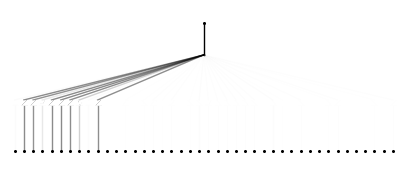

In [18]:
model1.final_kan.plot()

# Usign IGTD

In [23]:
from TINTOlib.refined import REFINED
from TINTOlib.igtd import IGTD

In [25]:
#Select the model and the parameters
problem_type = "regression"
image_size=16
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], random_seed=SEED)
name = f"IGTD_{image_size}x{image_size}"

#Define the dataset path and the folder where the images will be saved
images_folder = f"./HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [26]:
train_loader, val_loader, test_loader, attributes, imgs_shape = load_and_preprocess_data(
    X_train, X_test, X_val,
    images_folder=images_folder,
    image_model=image_model,
    problem_type=problem_type,
    batch_size=32
)

Loading ./HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_16x16/train\regression.csv...
Loading ./HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_16x16/val\regression.csv...
Loading ./HyNNImages/Regression/1000cameras/images_1000cameras_IGTD_16x16/test\regression.csv...
Images shape: (3, 16, 16)
Attributes: 10


In [27]:
dataset_name = '1000cameras'
name = f"IGTD"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=60, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)


Training completed in 246.73 seconds
Best model found at epoch 30/60
Best Train Loss: 330912.6596, Best Val Loss: 380447.6169
Best Train MSE: 332541.7188, Best Val MSE: 434970.5000
Best Train RMSE: 576.6643, Best Val RMSE: 659.5229
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


In [28]:
dataset_name = '1000cameras'
name = f"IGTD"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=16, epochs=120, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)


Training completed in 297.57 seconds
Best model found at epoch 99/120
Best Train Loss: 252571.6938, Best Val Loss: 367972.1029
Best Train MSE: 254601.3125, Best Val MSE: 419688.8750
Best Train RMSE: 504.5803, Best Val RMSE: 647.8340
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


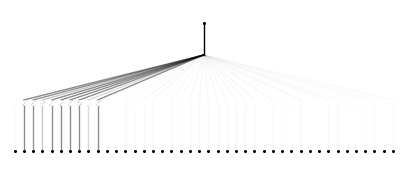

In [29]:
model1.final_kan.plot()

In [30]:
model1.final_kan.feature_score

tensor([0.0038, 0.1655, 0.1503, 0.0754, 0.1603, 0.1645, 0.1598, 0.1575, 0.0510,
        0.1580, 0.0011, 0.0002, 0.0075, 0.0037, 0.0087, 0.0100, 0.0015, 0.0091,
        0.0038, 0.0100, 0.0112, 0.0094, 0.0113, 0.0095, 0.0105, 0.0102, 0.0107,
        0.0005, 0.0103, 0.0036, 0.0029, 0.0113, 0.0009, 0.0031, 0.0099, 0.0075,
        0.0020, 0.0030, 0.0045, 0.0071, 0.0017, 0.0073], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [31]:
dataset_name = '1000cameras'
name = f"IGTD"
metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=16, epochs=240, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)


Training completed in 467.87 seconds
Best model found at epoch 135/240
Best Train Loss: 178589.5533, Best Val Loss: 359463.0391
Best Train MSE: 178265.0938, Best Val MSE: 409286.5938
Best Train RMSE: 422.2145, Best Val RMSE: 639.7551
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth


In [62]:
def compile_and_fit_2(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=10, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    best_val_loss = float('inf')
    best_model = None
    best_epoch = 0

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    pbar = tqdm(range(epochs), desc='description', ncols=100)
    #for epoch in range(epochs):
    for epoch in pbar:
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        pbar.set_description("| train_mse: %.2e | val_mse: %.2e | " % (train_mse, val_mse))
    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/ViT+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')
            
    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/ViT+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }

In [63]:
metrics = compile_and_fit_2(model1, train_loader, val_loader, test_loader, dataset_name, f"{dataset_name}_Model1", batch_size=32, epochs=5, min_lr=1e-4, max_lr=4e-3 , device='cuda', weight_decay=1e-2)

| train_loss: 4.43e+05 | val_loss: 4.35e+05 | val_rmse: 7.07e+02 | : 100%|█| 5/5 [01:07<00:00, 13.43



Training completed in 67.18 seconds
Best model found at epoch 5/5
Best Train Loss: 443002.1075, Best Val Loss: 434963.9277
Best Train MSE: 419667.5000, Best Val MSE: 499989.4375
Best Train RMSE: 647.8175, Best Val RMSE: 707.0993
Best model saved to models/Regression/1000cameras/ViT+MLP/1000cameras_Model1/best_model.pth
